# 1. Importing Libraries

In [2]:
!pip install split-folders
import splitfolders

In [3]:
input_folder = '/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset'
splitfolders.ratio(input_folder, output="/kaggle/working/", 
                   seed=42, ratio=(.8, .1, .1), 
                   group_prefix=None) # default values

Copying files: 1097 files [00:05, 191.73 files/s]


You should download timm library (pip install timm)

In [4]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 25.5 MB/s eta 0:00:00


In [5]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 855.4 kB/s eta 0:00:00 0:00:01


In [23]:
import torchvision
import torch
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import glob
import math
import timm
from PIL import ImageFilter
from einops import rearrange
from timm.loss import LabelSmoothingCrossEntropy

# 2. Configurations

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 10
lr = 0.001
batch_size = 32
num_workers = 4

In [25]:
class_names = os.listdir('/kaggle/working/train')
class_names.sort()
class_len = len(class_names)

# 3. Building Dataset

In [26]:
import glob
import random
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class Sports_Dataset(Dataset):
    
    def __init__(self, dataset_name, img_dir='/kaggle/working/train'):
        self.dataset_name = dataset_name
        self.img_dir = img_dir
        self.class_names = sorted([name for name in os.listdir(img_dir)])
        
        self.img_path = []
        for name in self.class_names:
            self.img_path.extend(glob.glob(f'{img_dir}/{name}/*.jpg'))
        
        self.labels = np.array([self.class_names.index(path.split('/')[-2]) for path in self.img_path])
        
        self.img_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),  # Convert image to tensor
        ])
        
    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        img = self.img_transforms(img)
        lbl = torch.tensor(self.labels[index], dtype=torch.long)
        
        return img, lbl
    
    def __len__(self):
        return len(self.img_path)

876


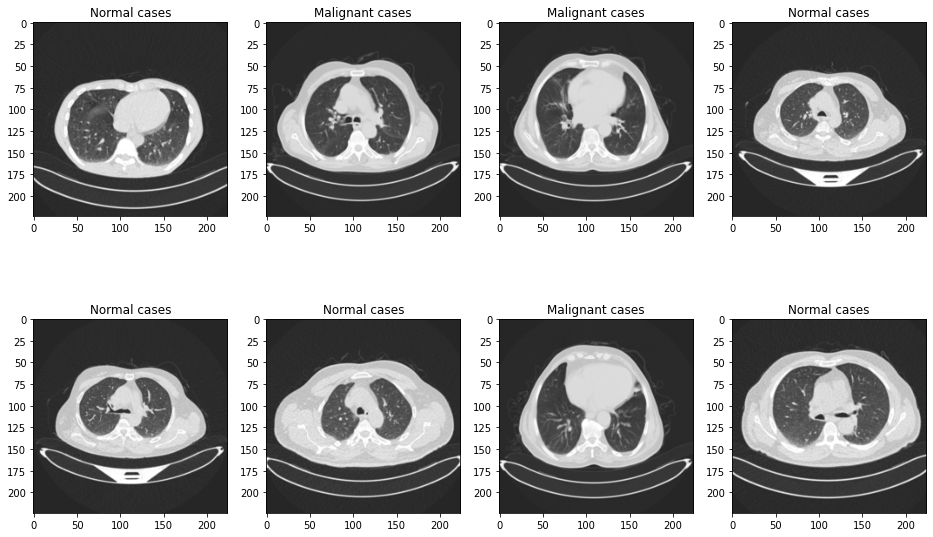

In [27]:
train_dataset = Sports_Dataset('train')
print(train_dataset.__len__())
_, ax = plt.subplots(2, 4, figsize=(16,10))

for i in range(8):
    data = train_dataset.__getitem__(np.random.choice(range(train_dataset.__len__())))

    image = data[0].cpu().detach().numpy().transpose(1, 2, 0) * 255
    image = image.astype(np.uint32)

    label = data[1]

    ax[i//4][i-(i//4)*4].imshow(image)
    ax[i//4][i-(i//4)*4].set_title(class_names[label])

# 4. Loading Deep Learning Model

In [29]:
# Feature visualization before fine-tuning (only pre-training weights)

features = []

def hook(module, input, output):
    features.append(output)

In [30]:
features = []

hook1 = model.layers[0].blocks[1].register_forward_hook(hook)
hook2 = model.layers[1].blocks[1].register_forward_hook(hook)
hook3 = model.layers[2].blocks[17].register_forward_hook(hook)
hook4 = model.layers[3].blocks[1].register_forward_hook(hook)

_ = model(data[0].unsqueeze(0).to(device))

hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()

In [33]:
from einops import rearrange

features[0] = rearrange(features[0], 'b x y dim -> b dim x y')
features[1] = rearrange(features[1], 'b x y dim -> b dim x y')
features[2] = rearrange(features[2], 'b x y dim -> b dim x y')
features[3] = rearrange(features[3], 'b x y dim -> b dim x y')

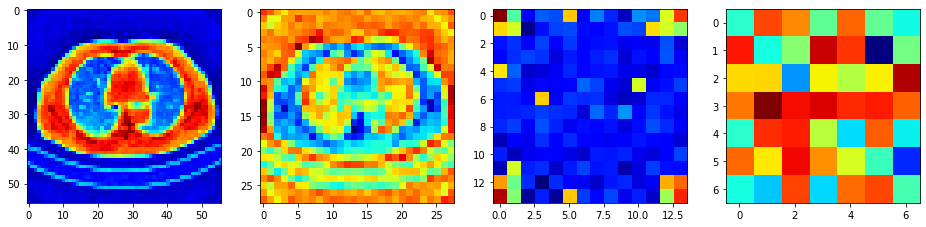

In [34]:
_, ax = plt.subplots(1, 4, figsize=(16,10))
for i in range(len(features)):
    ax[i].imshow(features[i][0].transpose(0, 2).transpose(0, 1).sum(-1).detach().cpu().numpy(), cmap='jet')

In [35]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

In [36]:
val_dataset = Sports_Dataset('valid')
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=1,
                                           shuffle=False)

In [ ]:
deit-tiny

Downloading:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/10: 100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Epoch [1/10], Loss: 0.8106, Accuracy: 69.52% | Val Loss: 0.4368, Val Accuracy: 83.49%


Epoch 2/10: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch [2/10], Loss: 0.3978, Accuracy: 85.27% | Val Loss: 0.3710, Val Accuracy: 86.24%


Epoch 3/10: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


Epoch [3/10], Loss: 0.2756, Accuracy: 89.04% | Val Loss: 0.2489, Val Accuracy: 92.66%


Epoch 4/10: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Epoch [4/10], Loss: 0.1435, Accuracy: 95.21% | Val Loss: 0.1274, Val Accuracy: 96.33%


Epoch 5/10: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch [5/10], Loss: 0.0489, Accuracy: 99.32% | Val Loss: 0.0886, Val Accuracy: 95.41%


Epoch 6/10: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


Epoch [6/10], Loss: 0.0353, Accuracy: 99.09% | Val Loss: 0.0162, Val Accuracy: 100.00%


Epoch 7/10: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


Epoch [7/10], Loss: 0.0120, Accuracy: 99.89% | Val Loss: 0.0149, Val Accuracy: 100.00%


Epoch 8/10: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]


Epoch [8/10], Loss: 0.0069, Accuracy: 99.89% | Val Loss: 0.0077, Val Accuracy: 100.00%


Epoch 9/10: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch [9/10], Loss: 0.0045, Accuracy: 100.00% | Val Loss: 0.0066, Val Accuracy: 100.00%


Epoch 10/10: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


Epoch [10/10], Loss: 0.0055, Accuracy: 99.89% | Val Loss: 0.0046, Val Accuracy: 100.00%
Test Accuracy: 100.00%


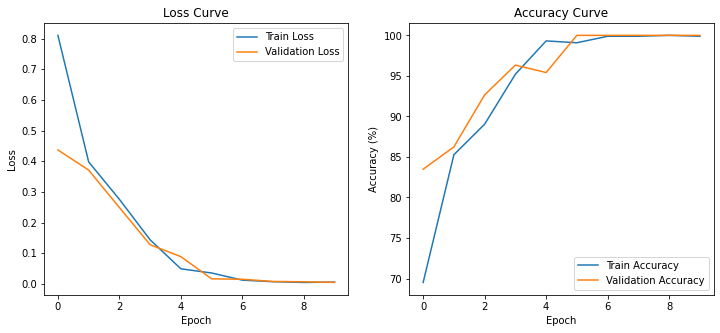

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os

# Custom Dataset
class Sports_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(img_dir))

        for label, class_name in enumerate(self.class_names):
            class_folder = os.path.join(img_dir, class_name)
            for img_name in os.listdir(class_folder):
                self.img_paths.append(os.path.join(class_folder, img_name))
                self.labels.append(label)
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Hyperparameters
batch_size = 128
num_workers = 3
num_epochs = 10
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets and DataLoaders
train_dataset = Sports_Dataset('/kaggle/working/train', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataset = Sports_Dataset('/kaggle/working/val', transform=transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Test dataset and DataLoader
test_dataset = Sports_Dataset('/kaggle/working/test', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Model
model = create_model('deit_tiny_patch16_224', pretrained=True, num_classes=len(train_dataset.class_names))
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Test evaluation
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [ ]:
efficient former

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Downloading:   0%|          | 0.00/49.4M [00:00<?, ?B/s]

Epoch 1/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch [1/50], Loss: 0.9931, Accuracy: 57.08% | Val Loss: 0.9233, Val Accuracy: 60.55%


Epoch 2/50: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


Epoch [2/50], Loss: 0.7767, Accuracy: 77.51% | Val Loss: 0.8021, Val Accuracy: 71.56%


Epoch 3/50: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


Epoch [3/50], Loss: 0.6092, Accuracy: 82.08% | Val Loss: 0.6866, Val Accuracy: 76.15%


Epoch 4/50: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


Epoch [4/50], Loss: 0.4756, Accuracy: 85.27% | Val Loss: 0.5652, Val Accuracy: 77.06%


Epoch 5/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch [5/50], Loss: 0.3953, Accuracy: 86.30% | Val Loss: 0.4872, Val Accuracy: 78.90%


Epoch 6/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch [6/50], Loss: 0.3471, Accuracy: 86.30% | Val Loss: 0.4034, Val Accuracy: 84.40%


Epoch 7/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [7/50], Loss: 0.3185, Accuracy: 86.64% | Val Loss: 0.3907, Val Accuracy: 83.49%


Epoch 8/50: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Epoch [8/50], Loss: 0.3008, Accuracy: 87.67% | Val Loss: 0.3172, Val Accuracy: 85.32%


Epoch 9/50: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]


Epoch [9/50], Loss: 0.2886, Accuracy: 87.79% | Val Loss: 0.3271, Val Accuracy: 88.07%


Epoch 10/50: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Epoch [10/50], Loss: 0.2826, Accuracy: 88.36% | Val Loss: 0.3181, Val Accuracy: 86.24%


Epoch 11/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [11/50], Loss: 0.2672, Accuracy: 88.81% | Val Loss: 0.2771, Val Accuracy: 88.07%


Epoch 12/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [12/50], Loss: 0.2532, Accuracy: 89.84% | Val Loss: 0.2887, Val Accuracy: 88.99%


Epoch 13/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [13/50], Loss: 0.2425, Accuracy: 89.50% | Val Loss: 0.2847, Val Accuracy: 88.99%


Epoch 14/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch [14/50], Loss: 0.2283, Accuracy: 89.95% | Val Loss: 0.2672, Val Accuracy: 90.83%


Epoch 15/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch [15/50], Loss: 0.2268, Accuracy: 90.18% | Val Loss: 0.2504, Val Accuracy: 89.91%


Epoch 16/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [16/50], Loss: 0.2053, Accuracy: 90.87% | Val Loss: 0.2321, Val Accuracy: 90.83%


Epoch 17/50: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Epoch [17/50], Loss: 0.2109, Accuracy: 90.98% | Val Loss: 0.2408, Val Accuracy: 90.83%


Epoch 18/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch [18/50], Loss: 0.1895, Accuracy: 92.24% | Val Loss: 0.2516, Val Accuracy: 89.91%


Epoch 19/50: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


Epoch [19/50], Loss: 0.1810, Accuracy: 92.58% | Val Loss: 0.2919, Val Accuracy: 88.07%


Epoch 20/50: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Epoch [20/50], Loss: 0.1751, Accuracy: 92.47% | Val Loss: 0.2224, Val Accuracy: 89.91%


Epoch 21/50: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


Epoch [21/50], Loss: 0.1655, Accuracy: 93.38% | Val Loss: 0.1939, Val Accuracy: 93.58%


Epoch 22/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch [22/50], Loss: 0.1659, Accuracy: 92.92% | Val Loss: 0.2032, Val Accuracy: 90.83%


Epoch 23/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [23/50], Loss: 0.1401, Accuracy: 94.98% | Val Loss: 0.2237, Val Accuracy: 88.99%


Epoch 24/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [24/50], Loss: 0.1340, Accuracy: 95.09% | Val Loss: 0.1699, Val Accuracy: 94.50%


Epoch 25/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [25/50], Loss: 0.1318, Accuracy: 95.32% | Val Loss: 0.2332, Val Accuracy: 90.83%


Epoch 26/50: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Epoch [26/50], Loss: 0.1309, Accuracy: 94.63% | Val Loss: 0.1011, Val Accuracy: 95.41%


Epoch 27/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [27/50], Loss: 0.1175, Accuracy: 95.55% | Val Loss: 0.1278, Val Accuracy: 94.50%


Epoch 28/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch [28/50], Loss: 0.0985, Accuracy: 96.46% | Val Loss: 0.1526, Val Accuracy: 94.50%


Epoch 29/50: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Epoch [29/50], Loss: 0.0937, Accuracy: 95.89% | Val Loss: 0.1712, Val Accuracy: 93.58%


Epoch 30/50: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Epoch [30/50], Loss: 0.0957, Accuracy: 96.80% | Val Loss: 0.1864, Val Accuracy: 90.83%


Epoch 31/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [31/50], Loss: 0.0887, Accuracy: 96.12% | Val Loss: 0.1630, Val Accuracy: 93.58%


Epoch 32/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [32/50], Loss: 0.1132, Accuracy: 95.55% | Val Loss: 0.2356, Val Accuracy: 88.99%


Epoch 33/50: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Epoch [33/50], Loss: 0.0811, Accuracy: 96.92% | Val Loss: 0.1304, Val Accuracy: 93.58%


Epoch 34/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [34/50], Loss: 0.1080, Accuracy: 96.00% | Val Loss: 0.2326, Val Accuracy: 89.91%


Epoch 35/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [35/50], Loss: 0.0621, Accuracy: 98.40% | Val Loss: 0.1932, Val Accuracy: 90.83%


Epoch 36/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch [36/50], Loss: 0.0793, Accuracy: 97.15% | Val Loss: 0.1427, Val Accuracy: 92.66%


Epoch 37/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [37/50], Loss: 0.0677, Accuracy: 97.37% | Val Loss: 0.1452, Val Accuracy: 93.58%


Epoch 38/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch [38/50], Loss: 0.0781, Accuracy: 96.92% | Val Loss: 0.2270, Val Accuracy: 89.91%


Epoch 39/50: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


Epoch [39/50], Loss: 0.0883, Accuracy: 96.12% | Val Loss: 0.2541, Val Accuracy: 91.74%


Epoch 40/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch [40/50], Loss: 0.0702, Accuracy: 96.92% | Val Loss: 0.1843, Val Accuracy: 88.99%


Epoch 41/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [41/50], Loss: 0.0606, Accuracy: 97.49% | Val Loss: 0.1289, Val Accuracy: 94.50%


Epoch 42/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [42/50], Loss: 0.0644, Accuracy: 97.60% | Val Loss: 0.1094, Val Accuracy: 96.33%


Epoch 43/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [43/50], Loss: 0.0649, Accuracy: 97.49% | Val Loss: 0.1353, Val Accuracy: 96.33%


Epoch 44/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [44/50], Loss: 0.0777, Accuracy: 96.69% | Val Loss: 0.1007, Val Accuracy: 97.25%


Epoch 45/50: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Epoch [45/50], Loss: 0.0555, Accuracy: 97.83% | Val Loss: 0.1376, Val Accuracy: 93.58%


Epoch 46/50: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Epoch [46/50], Loss: 0.0635, Accuracy: 97.60% | Val Loss: 0.0960, Val Accuracy: 96.33%


Epoch 47/50: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch [47/50], Loss: 0.0692, Accuracy: 97.72% | Val Loss: 0.0865, Val Accuracy: 95.41%


Epoch 48/50: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Epoch [48/50], Loss: 0.0553, Accuracy: 98.17% | Val Loss: 0.2165, Val Accuracy: 94.50%


Epoch 49/50: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Epoch [49/50], Loss: 0.0552, Accuracy: 97.83% | Val Loss: 0.1041, Val Accuracy: 97.25%


Epoch 50/50: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Epoch [50/50], Loss: 0.0514, Accuracy: 97.83% | Val Loss: 0.1511, Val Accuracy: 92.66%
Test Accuracy: 96.43%


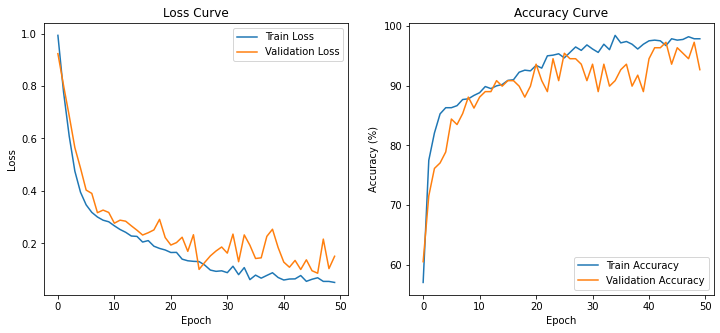

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os

# Custom Dataset
class Sports_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(img_dir))

        for label, class_name in enumerate(self.class_names):
            class_folder = os.path.join(img_dir, class_name)
            for img_name in os.listdir(class_folder):
                self.img_paths.append(os.path.join(class_folder, img_name))
                self.labels.append(label)
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Hyperparameters
batch_size = 128
num_workers = 5
num_epochs = 50
learning_rate = 5e-5
weight_decay = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Advanced Transforms with additional augmentations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets and DataLoaders
train_dataset = Sports_Dataset('/kaggle/working/train', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataset = Sports_Dataset('/kaggle/working/val', transform=transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Test dataset and DataLoader
test_dataset = Sports_Dataset('/kaggle/working/test', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Model
model = create_model('efficientformer_l1', pretrained=True, num_classes=len(train_dataset.class_names))
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training Loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Test evaluation
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()